Training set - 2023 Jan to 2024 May
Input window = 28

#### 1. Import the libraries

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

2024-11-13 21:19:49.503437: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 21:19:51.677084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731532792.424696    3169 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731532792.635309    3169 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 21:19:54.610774: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
pip install scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


#### 2. Pre processing the dataset

In [5]:
# load dataset
data = pd.read_csv('LL_data.csv')

In [6]:
data.tail()

,Received_Timestamp,Latitude,Longitude
796631,2024-08-16 20:26:55,6.301900,94.509340
796632,2024-08-16 20:41:52,6.304237,94.558950
796633,2024-08-16 20:44:07,6.304650,94.566895
796634,2024-08-16 20:44:45,6.304758,94.569090
796635,2024-08-16 21:01:24,6.306820,94.625694


In [7]:
# Remove the 'Longitude' column
data = data.drop(columns=['Latitude'])

In [8]:
data.tail()

,Received_Timestamp,Longitude
796631,2024-08-16 20:26:55,94.509340
796632,2024-08-16 20:41:52,94.558950
796633,2024-08-16 20:44:07,94.566895
796634,2024-08-16 20:44:45,94.569090
796635,2024-08-16 21:01:24,94.625694


In [9]:
data['Received_Timestamp'] = pd.to_datetime(data['Received_Timestamp'])  # Convert to datetime
data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')       # Convert to numeric, handling errors
#data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')     # Convert to numeric, handling errors
data = data.dropna()  # Drop rows with NaN values if any remain

In [10]:
data.set_index('Received_Timestamp', inplace=True)  # Set datetime as the index

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 796636 entries, 2023-01-01 00:36:49 to 2024-08-16 21:01:24
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Longitude  796636 non-null  float64
dtypes: float64(1)
memory usage: 12.2 MB


In [12]:
# Resample data to six-hour bins, handling empty bins with interpolation
data = data.resample('6H').mean()  # Bin by six hours with mean aggregation
data = data.interpolate(method='linear')  # Linear interpolation for missing bins

/tmp/ipykernel_3169/4293368568.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('6H').mean()  # Bin by six hours with mean aggregation


In [13]:
data.head()

,Longitude
Received_Timestamp,
2023-01-01 00:00:00,61.666054
2023-01-01 06:00:00,62.527122
2023-01-01 12:00:00,63.845577
2023-01-01 18:00:00,64.817208
2023-01-02 00:00:00,66.021411


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2376 entries, 2023-01-01 00:00:00 to 2024-08-16 18:00:00
Freq: 6h
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  2376 non-null   float64
dtypes: float64(1)
memory usage: 37.1 KB


In [15]:
scaler = MinMaxScaler()
# Ensure 'Latitude' is in a 2D format before scaling
data['Longitude'] = scaler.fit_transform(data[['Longitude']])

In [16]:
# Training set: Entire year of 2023 and up to August 2024
training_set = data.loc['2023':'2024-05']

# Testing set: Remaining months in 2024, starting from September 2024
testing_set = data.loc['2024-06':]


In [17]:
training_set.head()

,Longitude
Received_Timestamp,
2023-01-01 00:00:00,0.603455
2023-01-01 06:00:00,0.609879
2023-01-01 12:00:00,0.619715
2023-01-01 18:00:00,0.626964
2023-01-02 00:00:00,0.635948


In [18]:
testing_set.head()

,Longitude
Received_Timestamp,
2024-06-01 00:00:00,0.553587
2024-06-01 06:00:00,0.544791
2024-06-01 12:00:00,0.537876
2024-06-01 18:00:00,0.530367
2024-06-02 00:00:00,0.522785


#### 3. Sliding window approach

In [19]:
# Define the input window size (20 data points)
input_window_size = 28
# Define the output window size (1 data point)
output_window_size = 1
# Define the stride, which determines how much to move forward for each new window (1 data point)
stride = 1

In [20]:
# Apply sliding window to create sequences
# Initialize empty lists to store the input (X) and output (y) sequences
X, y = [], []

# Loop through the dataset to create windows of input and output sequences
for i in range(0, len(training_set) - input_window_size - output_window_size + 1, stride):
    # Define the input window, which is a slice of 20 data points
    input_window = training_set.iloc[i:i+input_window_size][['Longitude']]
    # Define the output window, which is a slice of 1 data point immediately following the input window
    output_window = training_set.iloc[i+input_window_size:i+input_window_size+output_window_size][['Longitude']]
    # Append the input window data to X and the last value of output window to y
    X.append(input_window.values)
    y.append(output_window.values[-1])

In [21]:
# Convert X and y lists to numpy arrays for model input
X, y = np.array(X), np.array(y)

# Print the number of samples created
print(f"Number of samples: {X.shape[0]}")
# Print the shape of the input (X) and output (y) arrays
print(f"Input shape: {X.shape}, Target shape: {y.shape}")

Number of samples: 2040
Input shape: (2040, 28, 1), Target shape: (2040, 1)


#### 4. Define LSTM model architecture

In [22]:
# Import necessary modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define a function to create an LSTM model with specified hyperparameters
def build_model(units=50, lstm_layers=2, dropout_rate=0.2, recurrent_dropout=0.2, activation='tanh', learning_rate=0.001):
    """
    Builds an LSTM model with the given parameters.

    Parameters:
        units (int): Number of units in each LSTM layer.
        lstm_layers (int): Number of stacked LSTM layers.
        dropout_rate (float): Dropout rate for regularization.
        recurrent_dropout (float): Dropout rate for the recurrent connections.
        activation (str): Activation function for LSTM layers.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model (Sequential): Compiled Keras model ready for training.
    """
    # Initialize a Sequential model
    model = Sequential()
    
    # Add LSTM layers
    for i in range(lstm_layers - 1):
        # Add intermediate LSTM layers with return_sequences=True for stacking
        model.add(LSTM(units=units, activation=activation, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
    
    # Add the final LSTM layer without return_sequences, as this is a many-to-one model
    model.add(LSTM(units=units, activation=activation, dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
    
    # Add a Dense layer with 1 unit for output (for regression)
    model.add(Dense(1))
    
    # Initialize the Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model using mean squared error (MSE) as the loss function, which is suitable for regression
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

# Initialize variables to keep track of the best model and lowest validation loss
best_model = None
best_loss = float('inf')  # Start with a high initial loss for comparison

# Define hyperparameter grids for tuning
units_list = [50, 100, 150]       # Different numbers of units to try in LSTM layers
layers_list = [1, 2, 3]           # Different numbers of LSTM layers to try
dropout_list = [0.2, 0.3, 0.5]    # Different dropout rates to test for regularization
learning_rates = [0.0001, 0.001, 0.005]  # Different learning rates for the optimizer
batch_sizes = [16, 32, 48]        # Different batch sizes for training

# Perform grid search across all combinations of hyperparameters
for units in units_list:
    for layers in layers_list:
        for dropout in dropout_list:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    # Print the current combination of hyperparameters being tested
                    print(f"Training model with units={units}, layers={layers}, dropout={dropout}, lr={lr}, batch_size={batch_size}")
                    
                    # Build a model with the current set of hyperparameters
                    model = build_model(units=units, lstm_layers=layers, dropout_rate=dropout, learning_rate=lr)
                    
                    # Define early stopping to stop training if validation loss doesn't improve for a number of epochs
                    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                    
                    # Define learning rate scheduler to reduce learning rate if validation loss plateaus
                    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
                    
                    # Train the model on the data with a validation split of 30%
                    # Early stopping and learning rate scheduler will be used as callbacks
                    history = model.fit(X, y, 
                                        epochs=100, 
                                        batch_size=batch_size, 
                                        validation_split=0.3, 
                                        callbacks=[early_stopping, lr_scheduler], 
                                        verbose=1)
                    
                    # Retrieve the minimum validation loss achieved during training
                    val_loss = min(history.history['val_loss'])
                    
                    # Check if the current model has achieved a lower validation loss than the best so far
                    if val_loss < best_loss:
                        # Update the best model and best loss
                        best_loss = val_loss
                        best_model = model
                        best_params = (units, layers, dropout, lr, batch_size)
                        best_history = history

# At the end of the search, 'best_model' contains the model with the lowest validation loss
# 'best_params' holds the parameters that yielded the best model, and 'best_history' contains the training history


Training model with units=50, layers=1, dropout=0.2, lr=0.0001, batch_size=16
Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2062 - val_loss: 0.0252 - learning_rate: 1.0000e-04
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0485 - val_loss: 0.0170 - learning_rate: 1.0000e-04
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0416 - val_loss: 0.0222 - learning_rate: 1.0000e-04
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0278 - val_loss: 0.0343 - learning_rate: 1.0000e-04
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0163 - val_loss: 0.0595 - learning_rate: 1.0000e-04
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0102 - val_loss: 0.0689 - learning_rate: 5.0000e-05
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - val_loss: 0.0736 - learning_rate: 5.0000e-05
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - val_loss: 0.074

2024-11-13 21:20:08.962083: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


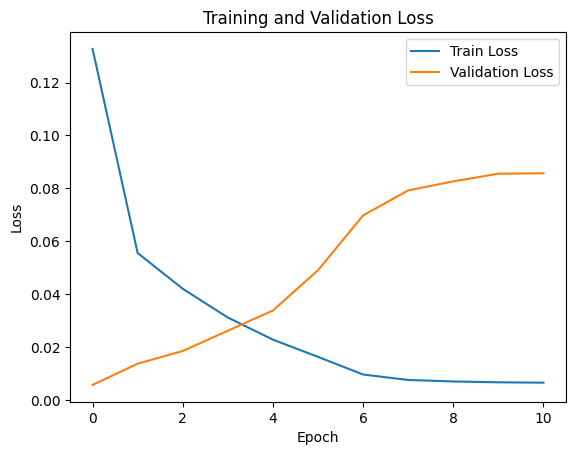

In [23]:
# Plot the training history of the best model
# Plot the loss and validation loss over epochs for the best model
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Output the best model parameters
# Print the best hyperparameters found in the grid search
print(f"Best model parameters: Units={best_params[0]}, Layers={best_params[1]}, Dropout={best_params[2]}, Learning Rate={best_params[3]}, Batch Size={best_params[4]}")

Best model parameters: Units=150, Layers=2, Dropout=0.2, Learning Rate=0.0001, Batch Size=48


In [25]:
#best_model.save('LL Prediction 1.h5')

### Testing Part

#### 1) Load the model

In [26]:
best_model

<Sequential name=sequential_191, built=True>

#### 2) Window sampling for testing set

In [27]:
import numpy as np

# Parameters for window sampling
input_window_size = 28
output_window_size = 1
stride = 1

# Initialize lists to store the input (X_test) and output (y_test) sequences for testing set
X_test, y_test = [], []

# Loop through the testing set to create windows of input and output sequences
for i in range(0, len(testing_set) - input_window_size - output_window_size + 1, stride):
    # Define the input window (20 data points)
    input_window = testing_set.iloc[i:i+input_window_size][['Longitude']]
    # Define the output window (1 data point immediately following the input window)
    output_window = testing_set.iloc[i+input_window_size:i+input_window_size+output_window_size][['Longitude']]
    # Append the input window to X_test and the last value of output window to y_test
    X_test.append(input_window.values)
    y_test.append(output_window.values[-1])

# Convert X_test and y_test lists to numpy arrays for model input
X_test, y_test = np.array(X_test), np.array(y_test)

# Print the number of samples created for testing
print(f"Number of test samples: {X_test.shape[0]}")
print(f"Test input shape: {X_test.shape}, Test target shape: {y_test.shape}")

Number of test samples: 280
Test input shape: (280, 28, 1), Test target shape: (280, 1)


#### 3) Test the Testing Set Using the Imported Model

In [28]:
best_model

<Sequential name=sequential_191, built=True>

In [29]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


#### 4) Calculate Error on the Testing Set

In [30]:
y_test

array([[0.54440153],
       [0.5554638 ],
       [0.56382811],
       [0.56829003],
       [0.57425237],
       [0.58313585],
       [0.59026783],
       [0.59282236],
       [0.59170273],
       [0.58827891],
       [0.5824468 ],
       [0.57443593],
       [0.56937078],
       [0.56276703],
       [0.55471535],
       [0.54800752],
       [0.54159654],
       [0.53394411],
       [0.52558359],
       [0.51511276],
       [0.50573748],
       [0.49511316],
       [0.48642578],
       [0.47728882],
       [0.46855368],
       [0.46134796],
       [0.45659069],
       [0.45025845],
       [0.443922  ],
       [0.43895003],
       [0.43470956],
       [0.43094242],
       [0.42736628],
       [0.42386545],
       [0.42021978],
       [0.41574869],
       [0.41095753],
       [0.40547303],
       [0.3987972 ],
       [0.39201651],
       [0.38729488],
       [0.38622759],
       [0.38631725],
       [0.38630336],
       [0.38635949],
       [0.38536097],
       [0.38400286],
       [0.377

In [31]:
y_pred

array([[0.50541157],
       [0.5061922 ],
       [0.5075259 ],
       [0.50940955],
       [0.5117878 ],
       [0.5146149 ],
       [0.51787096],
       [0.5215247 ],
       [0.52545553],
       [0.5295146 ],
       [0.533548  ],
       [0.5373903 ],
       [0.5408771 ],
       [0.54391515],
       [0.5464192 ],
       [0.5483157 ],
       [0.5495771 ],
       [0.55020076],
       [0.5501848 ],
       [0.54953206],
       [0.54822856],
       [0.54628706],
       [0.5437129 ],
       [0.540547  ],
       [0.5368265 ],
       [0.53257746],
       [0.52787095],
       [0.5228023 ],
       [0.51744115],
       [0.5118631 ],
       [0.50612336],
       [0.50030875],
       [0.49450392],
       [0.48875415],
       [0.48308828],
       [0.4775463 ],
       [0.4721595 ],
       [0.46693966],
       [0.46187565],
       [0.45693812],
       [0.45209575],
       [0.4473225 ],
       [0.4426678 ],
       [0.43819293],
       [0.4339372 ],
       [0.4299377 ],
       [0.42621425],
       [0.422

In [32]:
from sklearn.metrics import mean_squared_error

# Calculate MSE between predicted and actual values
error = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the Testing Set: {error}")

Mean Squared Error on the Testing Set: 0.009359235248420524


In [33]:
# Get the original data for predicted cells and add it to testing set as a new column
# Convert predictions to a DataFrame for easier concatenation
predictions_df = pd.DataFrame(y_pred, columns=['Predicted_Longitude'])

In [34]:
predictions_df.head()

,Predicted_Longitude
0,0.505412
1,0.506192
2,0.507526
3,0.509410
4,0.511788


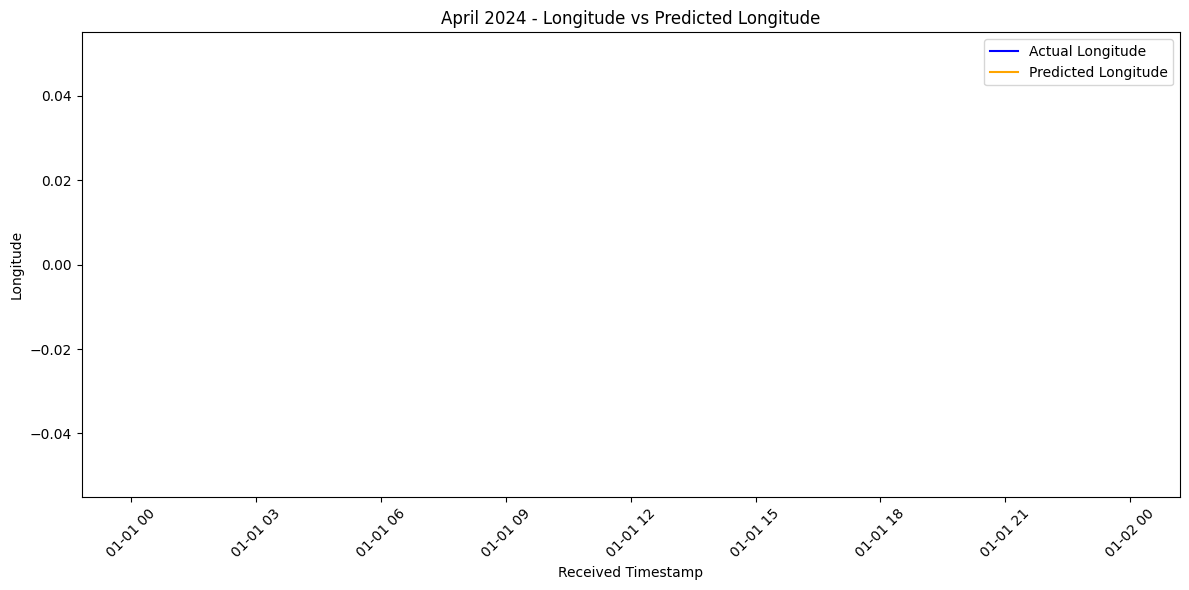

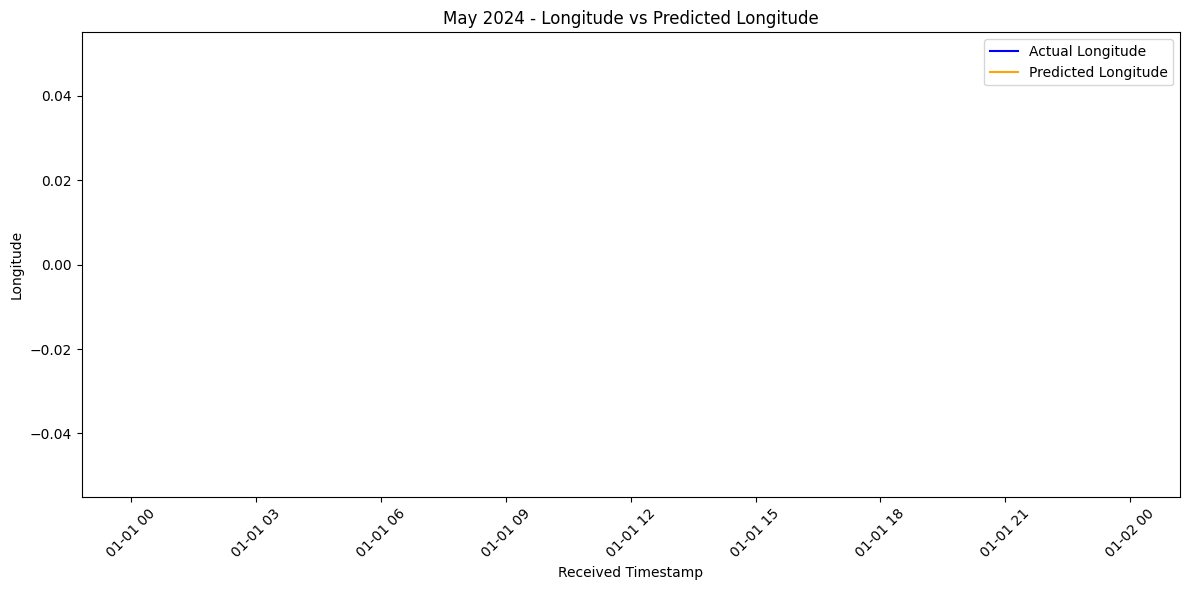

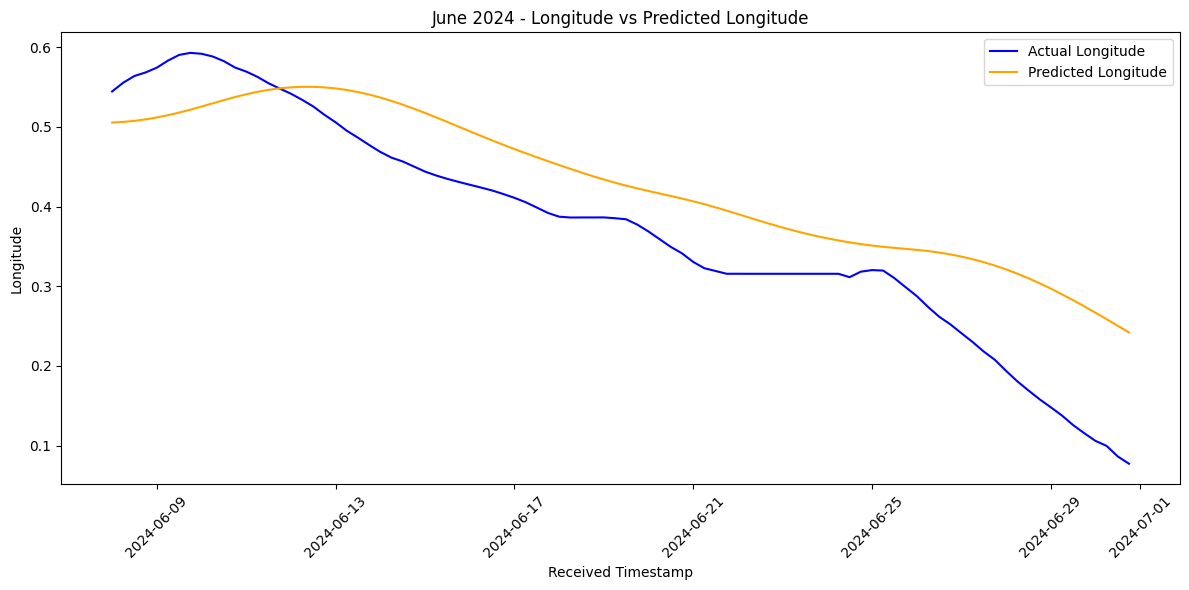

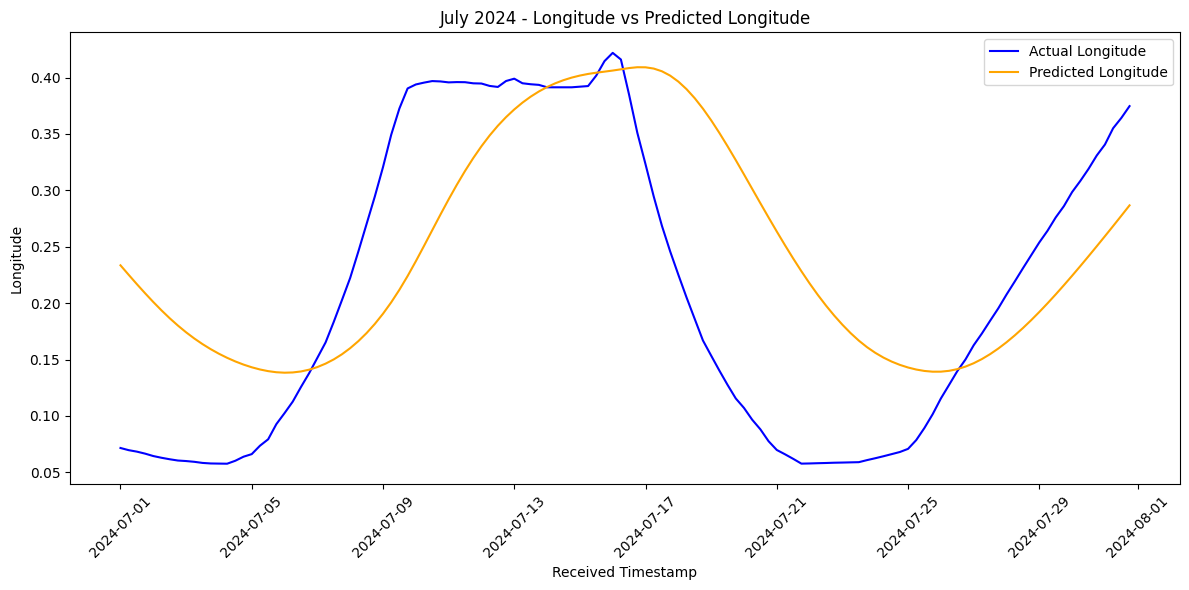

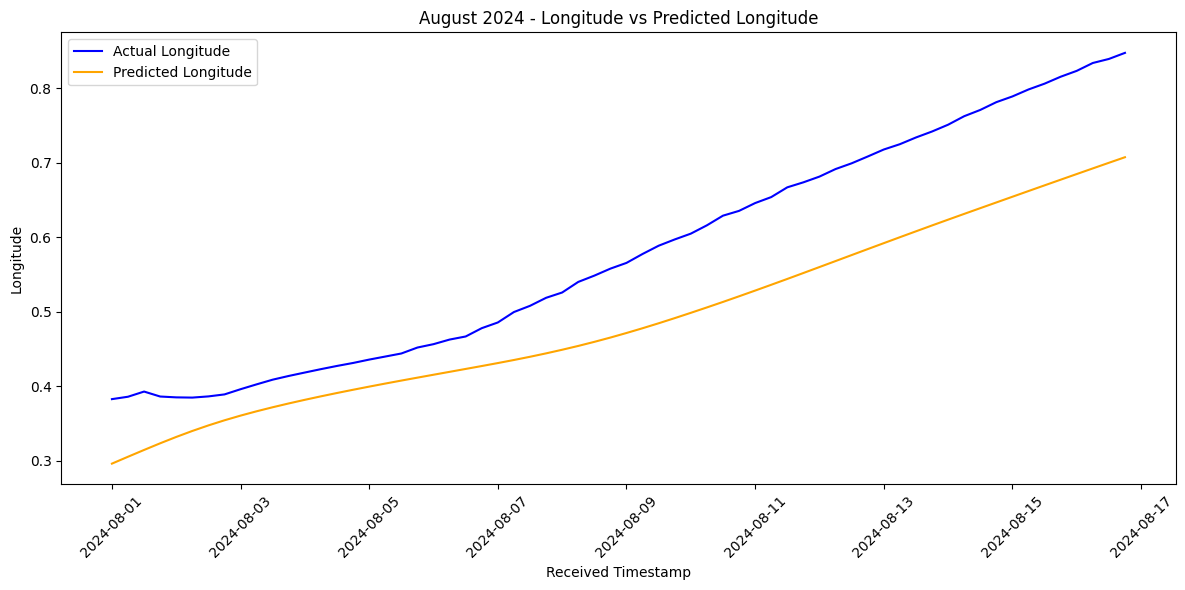

In [35]:
# Convert the predictions (y_pred) into a DataFrame for easy handling with timestamps
# We assume `testing_set.index[input_window_size:]` matches the `y_pred` in length
predicted_longitude = pd.DataFrame(y_pred, index=testing_set.index[input_window_size:], columns=['Predicted_Longitude'])

# Add the 'Longitude' column from `testing_set` as the true values for comparison
testing_longitudes = testing_set[['Longitude']].iloc[input_window_size:]  # Skip initial window

# Define the months for filtering and specific timestamps for illustration
months = {
    'April': '2024-04',
    'May': '2024-05',
    'June': '2024-06',
    'July': '2024-07',
    'August': '2024-08'
}

# Plot each month's data
for month_name, month_str in months.items():
    # Filter data for the entire month
    monthly_actual_data = testing_longitudes[testing_longitudes.index.to_period('M') == month_str]
    monthly_predicted_data = predicted_longitude[predicted_longitude.index.to_period('M') == month_str]
    
    # Plot actual vs predicted longitude values for the month
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_actual_data.index, monthly_actual_data['Longitude'], label='Actual Longitude', color='blue')
    plt.plot(monthly_predicted_data.index, monthly_predicted_data['Predicted_Longitude'], label='Predicted Longitude', color='orange')
    
    # Formatting the plot
    plt.title(f'{month_name} 2024 - Longitude vs Predicted Longitude')
    plt.xlabel('Received Timestamp')
    plt.ylabel('Longitude')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [36]:
y_test_real = scaler.inverse_transform(y_test)
#y_test = y_test.reshape(-1, 1)  # Reshape if necessary
#y_pred = y_pred.reshape(-1, 1)  # Reshape if necessary

In [37]:
y_test_real

array([[ 53.75052789],
       [ 55.23332034],
       [ 56.35447688],
       [ 56.95255504],
       [ 57.75175071],
       [ 58.94249819],
       [ 59.89847245],
       [ 60.24088309],
       [ 60.09080768],
       [ 59.63187681],
       [ 58.85013704],
       [ 57.77635611],
       [ 57.09741943],
       [ 56.21225009],
       [ 55.13299727],
       [ 54.23387556],
       [ 53.37454492],
       [ 52.34880912],
       [ 51.22816036],
       [ 49.82464357],
       [ 48.56797607],
       [ 47.14388568],
       [ 45.97942391],
       [ 44.75470054],
       [ 43.58383804],
       [ 42.61797834],
       [ 41.98031184],
       [ 41.13153507],
       [ 40.28219329],
       [ 39.61574802],
       [ 39.04735182],
       [ 38.54240309],
       [ 38.06305435],
       [ 37.59380206],
       [ 37.10513423],
       [ 36.50582598],
       [ 35.86361642],
       [ 35.12847157],
       [ 34.23363883],
       [ 33.32475172],
       [ 32.69186195],
       [ 32.54880178],
       [ 32.5608196 ],
       [ 32

In [38]:
y_pred_real = scaler.inverse_transform(y_pred)
y_pred_real

array([[ 4.85242882e+01],
       [ 4.86289253e+01],
       [ 4.88076973e+01],
       [ 4.90601807e+01],
       [ 4.93789597e+01],
       [ 4.97579079e+01],
       [ 5.01943550e+01],
       [ 5.06841049e+01],
       [ 5.12109947e+01],
       [ 5.17550735e+01],
       [ 5.22957115e+01],
       [ 5.28107376e+01],
       [ 5.32781105e+01],
       [ 5.36853333e+01],
       [ 5.40209770e+01],
       [ 5.42751846e+01],
       [ 5.44442635e+01],
       [ 5.45278587e+01],
       [ 5.45257187e+01],
       [ 5.44382248e+01],
       [ 5.42635040e+01],
       [ 5.40032654e+01],
       [ 5.36582222e+01],
       [ 5.32338638e+01],
       [ 5.27351646e+01],
       [ 5.21656189e+01],
       [ 5.15347595e+01],
       [ 5.08553505e+01],
       [ 5.01367416e+01],
       [ 4.93890572e+01],
       [ 4.86196976e+01],
       [ 4.78403053e+01],
       [ 4.70622215e+01],
       [ 4.62915192e+01],
       [ 4.55320625e+01],
       [ 4.47892151e+01],
       [ 4.40671654e+01],
       [ 4.33674927e+01],
       [ 4.2